In [3]:
from astir.data import from_csv_yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import torch
import math
import yaml
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import rand_score, accuracy_score, precision_score, f1_score

In [ ]:
# if save session
import dill
dill.dump_session('cytof_notebook_astir_env.db')

In [ ]:
# restore session
import dill
dill.load_session('cytof_notebook_astir_env.db')

# Run Astir on CyTOF

In [20]:
expression_mat_path= 'C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\CyTOF_TNBC\\input_data\\TNBC_Data_origin.csv'
yaml_marker_path = "C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\CyTOF_TNBC\\cell_type_descr_astir.yml"
output_path = "C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\CyTOF_TNBC\\output_data\\Astir_benchmarking\\"

In [11]:
# ast = from_csv_yaml(expression_mat_path, marker_yaml=yaml_marker_path)
df_gex = pd.read_csv(expression_mat_path, low_memory=False)
cols = ['Vimentin', 'SMA','FoxP3', 'Lag3', 'CD4', 
        'CD16', 'CD56', 'PD1', 'CD31','PD-L1', 
        'EGFR', 'Ki67', 'CD209', 'CD11c', 'CD138', 
        'CD163','CD68', 'CD8', 'CD3', 'IDO', 
        'Keratin17', 'CD63','CD45RO', 'CD20', 'p53', 
        'Beta catenin', 'HLA-DR', 'CD11b', 'CD45',
        'Pan-Keratin', 'MPO','Keratin6']

df_gex = df_gex[cols]
scaler = MinMaxScaler()
df_gex.loc[:,(cols)] = scaler.fit_transform(df_gex[cols])
from astir.astir import Astir
with open(yaml_marker_path, "r") as stream:
    marker_dict = yaml.safe_load(stream)
ast = Astir(df_gex, marker_dict)
print(ast)

Astir object, 8 cell types, 197678 cells


training restart (final):   4%|▍         | 45/1000 [ 5.97s/epochs, current loss: -5219718.5]


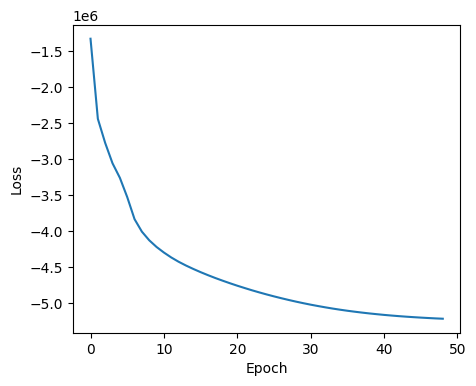

In [12]:
# Create batch size proportional to the number of cells

N = ast.get_type_dataset().get_exprs_df().shape[0]
batch_size = int(N/100)
# Number of training epochs
max_epochs = 1000
# Set learning rate
learning_rate = 2e-3
# Set initial epochs
initial_epochs = 3

ast.fit_type(max_epochs = max_epochs,
             batch_size = batch_size,
             learning_rate = learning_rate,
             n_init_epochs = initial_epochs)

# get astir result
Astir_result = ast.get_celltypes()

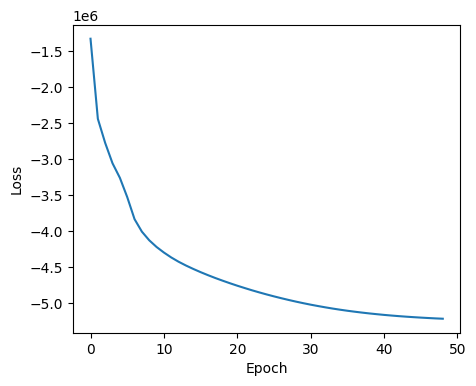

In [21]:
# plot loss function
plt.figure(figsize=(5,4))
plt.plot(np.arange(len(ast.get_type_losses())), ast.get_type_losses())
plt.ylabel("Loss")
plt.xlabel("Epoch")

plt.savefig("{}Cytof_lossfunc.svg".format(output_path))
plt.show()

In [22]:
Astir_result.to_csv("{}Cytof_lv2_benchmarking.csv".format(output_path))

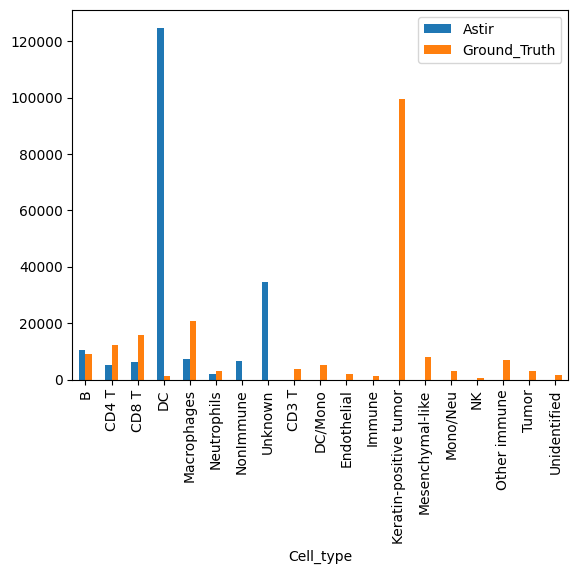

In [23]:
sample_data = pd.read_csv(expression_mat_path,low_memory=False)
Other_stat = pd.DataFrame(np.array(np.unique(list(Astir_result["cell_type"]), return_counts=True)).T, columns=("Cell_type", "Astir"))
Truth_stat = pd.DataFrame(np.array(np.unique(list(sample_data["DetailedGroup"]), return_counts=True)).T, columns=("Cell_type", "Ground_Truth"))
Stat_merged = pd.merge(Other_stat, Truth_stat, how="outer", on=["Cell_type"])
Stat_merged["Astir"] = pd.to_numeric(Stat_merged["Astir"])
Stat_merged["Ground_Truth"] = pd.to_numeric(Stat_merged["Ground_Truth"])
Stat_merged.plot(x="Cell_type",
        kind='bar',
        stacked=False)

plt.savefig("{}Cytof_num_level2.svg".format(output_path))
plt.show()

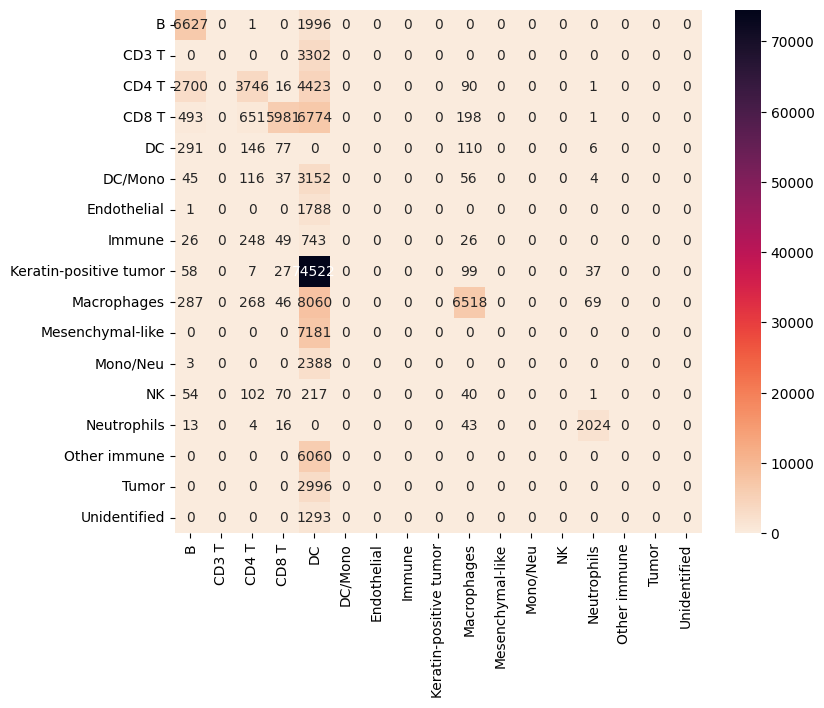

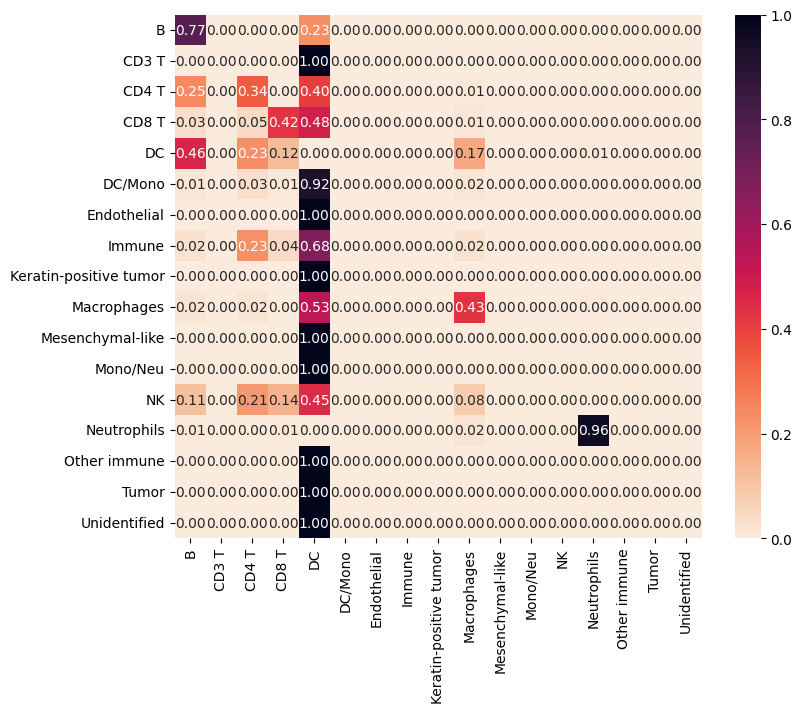

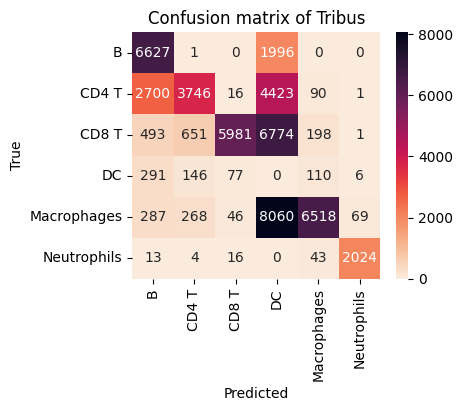

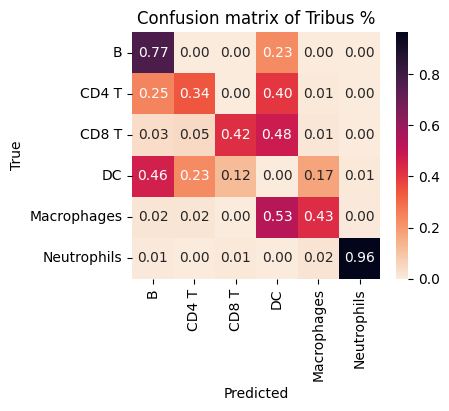

c:\Users\Localadmin_kangzigi\.conda\envs\astir\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Rand score = 0.6079010435392936, Accuracy score = 0.12594218881210859, Precision score = 0.25765621583342646, F1 score = 0.16162550669373224


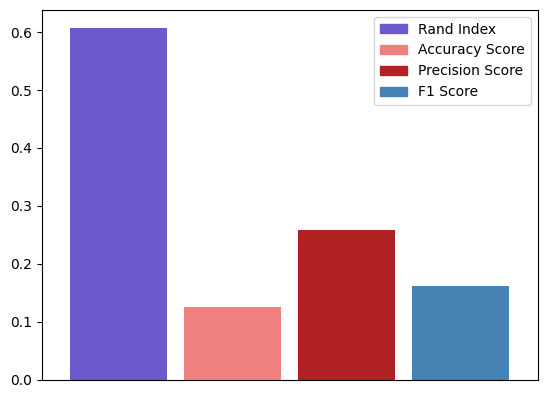

In [24]:
# "original_labels" list of the "ground_truth labels"

sample_data = pd.read_csv(expression_mat_path,low_memory=False)
original_labels = np.array(sample_data["DetailedGroup"]).tolist()
astir_labels = list(Astir_result["cell_type"])
original_label_types = np.unique(original_labels)
tribus_labels = [ 'other_Global' if label == 'Unknown' or label == 'Other' else label for label in astir_labels]

cm = metrics.confusion_matrix(original_labels, astir_labels, labels=original_label_types)
df_cm = pd.DataFrame(cm, index = original_label_types,
                  columns = original_label_types)
fig, ax = plt.subplots(figsize = (len(np.unique(original_label_types))*0.5, len(np.unique(original_label_types))*0.4))         # Sample figsize in inches
sns.heatmap(df_cm, fmt='g', annot=True, cmap=sns.cm.rocket_r)

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cmn = pd.DataFrame(cmn, index = original_label_types,
                  columns = original_label_types)
fig, ax = plt.subplots(figsize = (len(np.unique(original_label_types))*0.5, len(np.unique(original_label_types))*0.4)) 
sns.heatmap(df_cmn, fmt=".2f", annot=True, cmap=sns.cm.rocket_r)


# Plot confusion matrix of overlapping cell labels

cm_labels = np.intersect1d(np.unique(list(Astir_result["cell_type"])), np.unique(original_labels))
cm = metrics.confusion_matrix(original_labels, 
                    astir_labels, 
                    labels = cm_labels)
                                                        
df_cm = pd.DataFrame(cm, index = cm_labels,
                columns = cm_labels)
plt.figure(figsize = (len(np.unique(astir_labels))*0.5, len(np.unique(astir_labels))*0.4))
sns.heatmap(df_cm, fmt='g', annot=True, cmap=sns.cm.rocket_r)
plt.title('Confusion matrix of Tribus')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.savefig("{}Cytof_cm_level2.svg".format(output_path))
plt.show()

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cmn = pd.DataFrame(cmn, index = cm_labels,
                    columns = cm_labels)
plt.figure(figsize = (len(np.unique(astir_labels))*0.5, len(np.unique(astir_labels))*0.4))
sns.heatmap(df_cmn, fmt='.2f', annot=True, cmap=sns.cm.rocket_r)
plt.title('Confusion matrix of Tribus %')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.savefig("{}Cytof_cmn_level2.svg".format(output_path))
plt.show()

# Calculate average accuracy metrics and visualization
RI_avg = rand_score(original_labels, astir_labels) #between 0-1
AS_avg = accuracy_score(original_labels, astir_labels)
PS_avg = precision_score(original_labels, astir_labels, average='weighted')
F1_avg = f1_score(original_labels, astir_labels, average="weighted")
print("Rand score = {}, Accuracy score = {}, Precision score = {}, F1 score = {}".format(RI_avg, AS_avg, PS_avg, F1_avg))
df = pd.DataFrame([RI_avg, AS_avg, PS_avg, F1_avg], columns=['Value'], index = ["Rand Index", "Accuracy Score", "Precision Score", "F1 Score"])

df.to_csv("{}Cytof_benchmarking_stats_report_all.csv".format(output_path))

colors = {"Rand Index": 'slateblue', "Accuracy Score": 'lightcoral', "Precision Score": 'firebrick', "F1 Score":'steelblue'}
df.plot.bar(y='Value', width = 0.85, legend=False, 
            color=['slateblue', 'lightcoral', 'firebrick', 'steelblue'], rot=0, xticks=[])
metric_labels = ["Rand Index", "Accuracy Score", "Precision Score", "F1 Score"]
handles = [plt.Rectangle((0,0),1,1, color=colors[l]) for l in metric_labels]
plt.legend(handles, metric_labels)

plt.savefig("{}Cytof_metrics_average.svg".format(output_path))
plt.show()

                 TN      FP     FN    TP  accuracy
B            184592    3971   2488  6627  0.967326
CD4 T        183697    1543   8692  3746  0.948224
CD8 T        181642     338   9717  5981  0.949134
DC            71538  124895   1245     0  0.361892
Macrophages  176400     662  14098  6518  0.925333
Neutrophils  194541     119    994  2024  0.994370
              precision    recall  f1-score  support
B              0.625307  0.727043  0.672348   9115.0
CD4 T          0.708262  0.301174  0.422632  12438.0
CD8 T          0.946511  0.381004  0.543307  15698.0
DC             0.000000  0.000000  0.000000   1245.0
Macrophages    0.907799  0.316162  0.468988  20616.0
Neutrophils    0.944470  0.670643  0.784344   3018.0
micro avg      0.159157  0.400708  0.227825  62130.0
macro avg      0.688725  0.399338  0.481937  62130.0
weighted avg   0.819781  0.400708  0.514241  62130.0


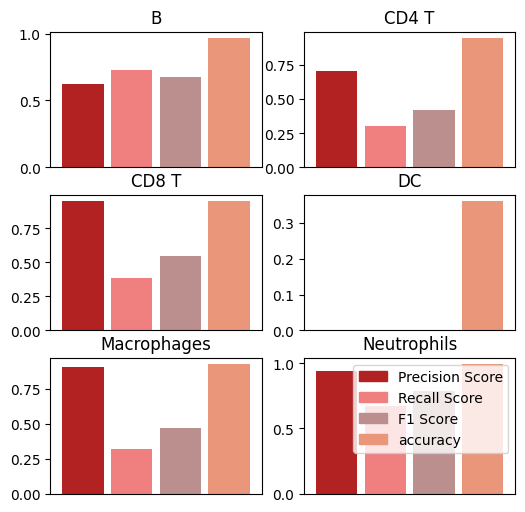

In [25]:
# accuracy metrics per cell type
celltype_pred = astir_labels
celltype_true = original_labels

classes = np.intersect1d(np.unique(celltype_pred), np.unique(celltype_true))

stats_array = metrics.multilabel_confusion_matrix(celltype_true, celltype_pred, labels=classes)
stats_df = pd.DataFrame()
for i in range(len(stats_array)):
    stats_df = pd.concat([stats_df, pd.DataFrame(stats_array[i].flatten()).T])
stats_df.columns = ["TN", "FP", "FN", "TP"]
stats_df.index = [classes]
stats_df["accuracy"] = (stats_df["TN"] + stats_df["TP"]) / (stats_df["TN"] + stats_df["TP"] + stats_df["FN"] + stats_df["FP"]) # in celesta paper they use this way to calculate Rand Index
print(stats_df)
stats_df.to_csv("{}Cytof_benchmarking_stats.csv".format(output_path))

report = metrics.classification_report(celltype_true, celltype_pred, labels=classes, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)
report_df.to_csv("{}Cytof_benchmarking_stats_report.csv".format(output_path))
# Support is the number of actual occurrences of the class in the specified dataset.

rows = math.ceil(len(np.intersect1d(np.unique(celltype_pred), np.unique(celltype_true))) / 2)
fig, ax = plt.subplots(rows, 2, figsize=(6,6))

for i in range(len(np.intersect1d(np.unique(celltype_pred), np.unique(celltype_true)))): 
    
    celltype = np.intersect1d(np.unique(celltype_pred), np.unique(celltype_true))[i]
    df = report_df.loc[celltype]
    df["accuracy"] = stats_df.iloc[i,-1].tolist()
    df = df[["precision", "recall", "f1-score", "accuracy"]]
    
    colors = {"Precision Score": 'firebrick', "Recall Score": 'lightcoral', "F1 Score":'rosybrown', "accuracy": 'darksalmon'}
    df.plot.bar(y='Value', ax=ax[int(i / 2)][i % 2], width = 0.85, 
                title="{}".format(celltype), legend=False, 
                color=['firebrick', 'lightcoral', 'rosybrown', 'darksalmon'], rot=0, xticks=[])

metric_labels = ["Precision Score", "Recall Score", "F1 Score", "accuracy"]
handles = [plt.Rectangle((0,0),1,1, color=colors[l]) for l in metric_labels]
plt.legend(handles, metric_labels)

plt.savefig("{}Cytof_metrics_per_celltype.svg".format(output_path))
plt.show()